# Springboard Data Science Career Track Program

## Capstone Project 2 - Company Industry Classification Final Report

#### Irene Yao

#### January 28, 2019

### <font color=#3090C7>INTRODUCTION</font>

According to Ernst & Young, US venture capital investment reached US$138b in 2018, spreading across 9,216 deals. With the exponential growth in startup formation and equity investments into those companies, being able to keep track of the entities and follow the money become crucial for both investors and investment service providers. One key step in the decision cycle is to have accurate data on the companies and decide how to analyze the entities from different perspectives including industries, development stages, and geographical locations, etc. In this project, I will focus on the classification of industry segments and how we could catalogue each company into one unique industry code based on the company's business description. The model used for cateloging is built as a supervised multiclassification problem with company description as the feature and industry segment as the label. The automatic classification method will provide information curators and users with a fast and scalable approach to data collection and potentially higher accuracy in cateloging by eliminating the human errors. 

### <font color=#3090C7>DESCRIPTION OF DATASET</font>

The data for this analysis was downloaded from [The Open Data 500 by The GovLab](http://www.opendata500.com/us/list/). It contains about 500 company profiles compiled by The GovLab through outreach campaigns, advice from experts and professional organizations, and research efforts. Information includes company name, url, founding year, headquarter, business description, and company category, etc. In this project, we will only use the "description" and "company_category" (industry segment) columns. The text description will be transformed into vectors and used as our features. The company_category is our label column.  

### <font color=#3090C7>DATA WRANGLING</font>

The "company_category" column identifies which industry the company belongs to. There are 18 categories in total. A few companies are lacking the company category and those records are removed. Two of the categories contain only 1 company each, and those 2 records are also deleted. Meanwhile, I cleaned up some misspelled industry codes and added a numeric column to encode the industry categories as integers.

In [106]:
## import packages
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
nlp = spacy.load('en')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [107]:
## read in the data
df = pd.read_csv('us_companies.csv')
print(df.columns)

Index(['company_name_id', 'company_name', 'url', 'year_founded', 'city',
       'state', 'country', 'zip_code', 'full_time_employees', 'company_type',
       'company_category', 'revenue_source', 'business_model', 'social_impact',
       'description', 'description_short', 'source_count', 'data_types',
       'example_uses', 'data_impacts', 'financial_info', 'last_updated'],
      dtype='object')


In [108]:
## cleanup empty and misspelled industry codes
df = df[df['company_category'].notnull()]
df.loc[df['company_category']=='Data/Technology,', 'company_category']='Data/Technology'
df.loc[df['company_category']=='Housing/Real Estate,', 'company_category']='Housing/Real Estate'

## removing industry codes that contain only 1 company
df = df[df['company_category']!='Aerospace and Defense']
df = df[df['company_category']!='Media']

print(df.company_category.unique())

['Data/Technology' 'Finance & Investment' 'Research & Consulting'
 'Governance' 'Environment & Weather' 'Business & Legal Services'
 'Healthcare' 'Lifestyle & Consumer' 'Transportation' 'Insurance'
 'Education' 'Energy' 'Scientific Research' 'Geospatial/Mapping'
 'Housing/Real Estate' 'Food & Agriculture']


In [109]:
## gather the feature and label columns
desc_ind = df[['description', 'company_category']]
print(desc_ind.shape)

(524, 2)


In [110]:
## encode the categories as integers
desc_ind['category_id']=df['company_category'].factorize()[0]
category_id_df = desc_ind[['company_category', 'category_id']].drop_duplicates().sort_values('category_id')

## create mapping on category_to_id and id_to_category
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'company_category']].values)
desc_ind.head()

,description,company_category,category_id
0,3 Round Stones produces a platform for publish...,Data/Technology,0
1,The company mission is to provide finance to s...,Finance & Investment,1
2,"At 5PSolutions, we wish to make all basic info...",Data/Technology,0
3,"Abt Associates is a mission-driven, internatio...",Research & Consulting,2
4,Accela powers thousands of services and millio...,Governance,3


After the data wrangling, we obtained 524 records with their business description, company_category and corresponding category_id. There are in total 16 categories (industry segments) left for analysis.  

### <font color=#3090C7>TEXT PRE-PROCESSING</font>

The business description is composed of free texts, which contains html tags, url, accented characters, and special characters, etc. It also contains numbers to describe address, company size, or user base, which are not directly relevant to our analysis. The following steps are thus taken to normalize the texts. 
* Remove html tags, urls, numbers, accented characters, special characters, extra spaces, and stopwords
* Expand contractions to change words such as we'll into we will, there're into there are
* Lemmatize text

In [111]:
## removing html tags
def remove_html_tag(text):
    tag_re = re.compile(r'<[^>]+>')
    text = tag_re.sub('', text)
    text = text.replace("\n","")
    return text

In [112]:
## removing url
def remove_url(text):
    text = re.sub('http\S+\s*', '', text)
    return text

In [113]:
## removing numbers
def remove_no(text):
    text = re.sub(r'\d+', '', text)
    return text

In [114]:
## expanding contractions
import re
from contractions import CONTRACTION_MAP

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [115]:
## removing accented characters
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [116]:
## removing special characters
def remove_special_characters(text):
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    return text

In [117]:
## lemmatizing text
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_!='-PRON-' else word.text for word in text])
    return text

In [118]:
## removing stopwords:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [119]:
## Normalize text corpus - altogether
def normalize_corpus(corpus, html_tag_removal=True, url_removal=True, number_removal = True, accented_char_removal=True, 
                     contraction_expansion=True, text_lower_case=True, text_lemmatization=True, 
                     special_char_removal=True, stopword_removal=True):
    normalized_corpus = []
    for doc in corpus:
        if html_tag_removal:
            doc = remove_html_tag(doc)
        if url_removal:
            doc = remove_url(doc)
        if number_removal:
            doc = remove_no(doc)
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        if contraction_expansion:
            doc = expand_contractions(doc)
        if text_lower_case:
            doc = doc.lower()
        if text_lemmatization:
            doc = lemmatize_text(doc)
        if special_char_removal:
            doc = remove_special_characters(doc)
        ## remove extra white spaces
        doc = re.sub(' +', ' ', doc)
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        
        normalized_corpus.append(doc)
    return normalized_corpus

In [120]:
## Normalize company description
description = desc_ind['description']
normalized_description = normalize_corpus(description)
desc_ind['normalized_description'] = normalized_description
desc_ind.head()

,description,company_category,category_id,normalized_description
0,3 Round Stones produces a platform for publish...,Data/Technology,0,round stone produce platform publish datum web...
1,The company mission is to provide finance to s...,Finance & Investment,1,company mission provide finance small business...
2,"At 5PSolutions, we wish to make all basic info...",Data/Technology,0,psolution wish make basic information differen...
3,"Abt Associates is a mission-driven, internatio...",Research & Consulting,2,abt associate mission drive international comp...
4,Accela powers thousands of services and millio...,Governance,3,accela power thousand service million transact...


### <font color=#3090C7>EXPLORATORY DATA ANALYSIS (EDA) & STATISTICAL INFERENCE</font> 

Before diving into building machine learning models, we will look at the number of companies in each category class.

Text(0, 0.5, 'Company Count')

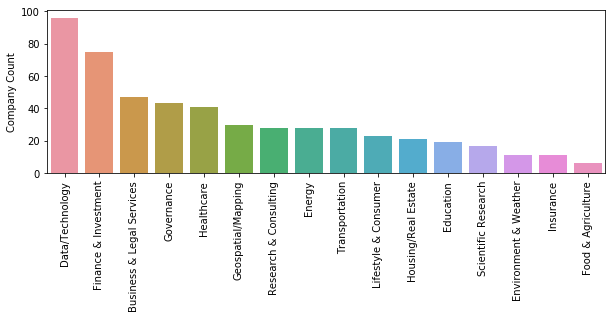

In [121]:
## number of companies in each company_category
fig, ax = plt.subplots(figsize=(10,3))
co_in_cat = desc_ind.company_category.value_counts()
_ = sns.barplot(x=co_in_cat.index, y=co_in_cat, ax=ax)
for i in _.get_xticklabels():
    i.set_rotation(90)
ax.set_ylabel("Company Count")

We notice that the number of companies per category is imbalanced, with most of the companies in the Data/Technology and Finance & Investment group. Since conventional machine learning algorithms tend to bias towards the major class, we will keep the imbalanced distribution in mind when training the data.

Next, I will show a word count to quickly get an idea of the most common words that appear in the description. 

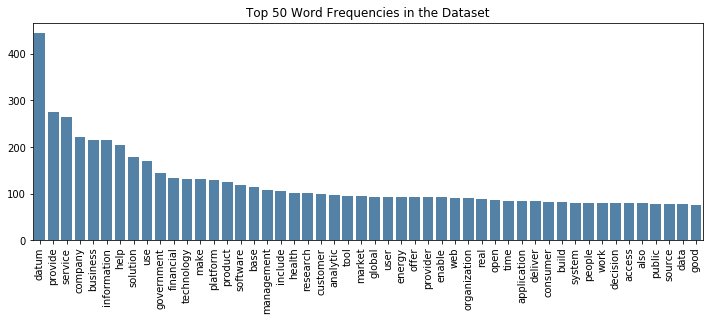

In [122]:
## word counts
all_words = desc_ind.normalized_description.str.split(expand=True).unstack().value_counts()
fig, ax = plt.subplots(figsize=(12,4))
_ = sns.barplot(x=all_words.index[0:50], y=all_words[0:50], ax=ax, color="steelblue")
plt.title('Top 50 Word Frequencies in the Dataset')
for i in _.get_xticklabels():
    i.set_rotation(90)

The above chart shows the top 50 most frequent words in the company summary. Among them, datum, provide, service, company, and business are the top 5 words used to describe the companies. In order to see if any of the words are particularly used for any industries, I will generate word clouds for all 16 industries. 

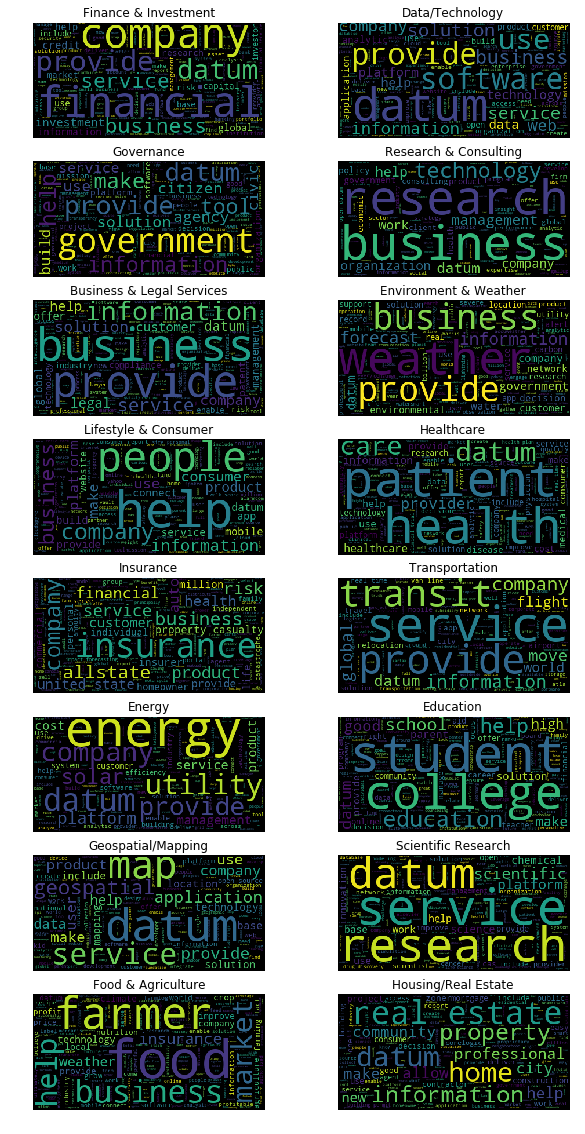

In [67]:
from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(ncols=2, nrows=8, figsize=(10,20))

def generate_wordcloud(topic, title, cat_id):
    wordcloud = WordCloud().generate(" ".join(topic))
    if cat_id%2==1:
        ax_row = cat_id//2
        ax[ax_row][0].imshow(wordcloud)#, interpolation='bilinear')
        ax[ax_row][0].set_title(title)
        ax[ax_row][0].axis("off")
        #plt.show()
    else:
        ax_row = cat_id//2
        ax[ax_row][1].imshow(wordcloud)#, interpolation='bilinear')
        ax[ax_row][1].set_title(title)
        ax[ax_row][1].axis("off")
        #plt.show()

for cat_id, cat in id_to_category.items():
    value = desc_ind[desc_ind['company_category']==cat]['normalized_description'].values
    generate_wordcloud(value, cat, cat_id)

We found that some of the words such as provide, service, company, and business are quite common in the description of all industries, yet don't reveal much information about the type of service the company provides. These may be the words we need to eliminate from the analysis. 

To get a better idea of how the words are distributed, let's explore the words in the corpus. I will use the TfidfVectorizer to extract the features. Since some of the words such as the company names are very unique to their own descriptions, I will add the parameter min_df=2 to filter for words that appear in at least 2 documents. I'm also interested in both the most frequent unigram and bigram words.

In [123]:
## text vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=2, ngram_range=(1,2))
features = tfidf.fit_transform(desc_ind['normalized_description']).toarray()
labels = desc_ind.category_id
features.shape

(524, 3624)

After vectorizing the words, we see that each of the 524 descriptions is represented by 3624 features, showing the tf-idf score for different unigrams and bigrams. We can then use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the industry segments. 

In [69]:
from sklearn.feature_selection import chi2
print("Most Correlated Unigrams and Bigrams for each industry")
print("")

N = 3
for indcode, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(-features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    chi2_value = np.array(features_chi2[0])[indices]
    unigram = [len(v.split(' '))==1 for v in feature_names]
    bigram = [not i for i in unigram]
    unigrams = feature_names[unigram]
    unigram_value = chi2_value[unigram]
    bigrams = feature_names[bigram]
    bigram_value = chi2_value[bigram]

    print(indcode)
    dict_uni = {"Unigram": unigrams[:N], "Unigram Chi2": unigram_value[:N], "Bigram": bigrams[:N]
                , "Bigram Chi2": bigram_value[:N]}
    df_uni = pd.DataFrame.from_dict(dict_uni).loc[:, ["Unigram", "Unigram Chi2", "Bigram", "Bigram Chi2"]]
    display(df_uni)

Most Correlated Unigrams and Bigrams for each industry

Business & Legal Services


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,legal,23.169131,individual business,9.046163
1,lawyer,12.846582,customer need,4.508171
2,patent,6.770733,background check,4.442675


Data/Technology


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,datum,5.181395,business intelligence,3.637256
1,demographic,4.376913,complex datum,3.262470
2,software,3.898663,enterprise datum,3.205333


Education


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,student,70.875412,student college,12.910004
1,college,58.340190,help parent,12.012365
2,aid,26.508216,school teacher,11.038416


Energy


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,energy,100.064870,energy datum,13.45330
1,solar,35.900085,energy management,13.22840
2,utility,19.881284,energy efficiency,12.73332


Environment & Weather


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,weather,61.796405,solution business,13.416328
1,forecast,18.590747,app deliver,10.378810
2,carbon,18.334691,environmental datum,8.251736


Finance & Investment


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,financial,15.885951,institutional client,5.241050
1,investment,15.266900,individual investor,4.464934
2,investor,13.557337,credit rating,4.316367


Food & Agriculture


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,food,74.594469,find local,11.749247
1,farmer,54.048532,available market,10.048238
2,farming,36.232088,health technology,9.834192


Geospatial/Mapping


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,map,27.497008,map datum,12.421722
1,geospatial,18.389584,datum collection,10.503421
2,navigation,14.181180,location base,6.459677


Governance


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,citizen,14.391516,local government,9.677492
1,legislative,13.112537,civic technology,4.936080
2,government,11.836985,code america,4.665531


Healthcare


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,patient,47.189338,health plan,12.348129
1,health,32.869214,clinical trial,10.433997
2,care,29.668346,care provider,9.159891


Housing/Real Estate


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,estate,58.731613,real estate,60.793055
1,real,17.540759,estate agent,15.532455
2,permit,16.622051,estate professional,12.267281


Insurance


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,insurance,111.967348,insurance financial,27.926749
1,casualty,22.463505,auto insurance,23.635972
2,watercraft,17.426867,property casualty,22.463505


Lifestyle & Consumer


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,weight,17.431761,weight loss,10.247805
1,eat,14.866746,consumer report,9.891763
2,yahoo,9.532937,use mobile,7.813908


Research & Consulting


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,consulting,18.853410,management consulting,14.863290
1,measurement,12.282955,consulting firm,13.851545
2,firm,8.904541,global management,12.374758


Scientific Research


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,chemical,33.077659,drug discovery,15.980704
1,cancer,20.902822,genomic datum,15.639425
2,scientific,17.293334,life science,12.200810


Transportation


,Unigram,Unigram Chi2,Bigram,Bigram Chi2
0,relocation,31.149619,van line,22.358012
1,move,24.893401,relocation company,15.656647
2,storage,23.541693,storage service,15.356687


Most of the terms in each category seem to be representative of the industry. 

### <font color=#3090C7>MACHINE LEARNING</font>

#### Baseline Model

Now we have all the features (the word vectors) and the labels (company_category), it's time to build our baseline model for the documents. Let's first try Naive Bayes. Since MultinomialNB is usually considered the most suitable algorithm for word counts, we will start with it. 

In [70]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [124]:
## train test split
X = desc_ind['normalized_description']
y = desc_ind['category_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [72]:
tfidf = TfidfVectorizer(min_df=2, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
feature_size = X_train_tfidf.toarray().shape[1]
print('Corpus Size: ', feature_size)

Corpus Size:  2505


In [73]:
## train the classifier
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [74]:
def get_prediction(model, X_train, X_test):
    y_predict_train = model.predict(X_train)
    y_predict = model.predict(X_test)
    return y_predict_train, y_predict
    
def calculate_accuracy(y_train, y_test, y_predict_train, y_predict):
    print('Accuracy on training set: ', metrics.accuracy_score(y_train, y_predict_train))
    print('Accuracy on test set: ', metrics.accuracy_score(y_test, y_predict))

In [75]:
## model evaluation using accuracy
y_predict_train, y_predict = get_prediction(clf, X_train_tfidf, X_test_tfidf)
calculate_accuracy(y_train, y_test, y_predict_train, y_predict)

Accuracy on training set:  0.4472934472934473
Accuracy on test set:  0.2658959537572254


In [76]:
def plot_confusion_matrix(y_test, y_predit, model):
    mat = confusion_matrix(y_test, y_predict)
    categories = [id_to_category[x] for x in model.classes_]
    total_value = mat.T.sum(axis=0)
    total_value = total_value.astype('str')
    total_string = np.array([' (total '] * 16)
    brackets = np.array([')'] * 16)
    total = np.core.defchararray.add(total_string, total_value)
    total = np.core.defchararray.add(total, brackets)
    x_label = np.core.defchararray.add(categories, total)
    
    recall_matrix = mat.T.astype("float")
    matrix_sum = recall_matrix.sum(axis=0)
    for i, row in enumerate(recall_matrix):
        for j, item in enumerate(row):
            if i==j:
                new_val = round(row[j]/matrix_sum[j],1)
                row[j] = new_val
            else:
                row[j] = 0
                #print(new_val)
    
    fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=x_label
                , yticklabels=categories, ax=ax0)
    sns.heatmap(recall_matrix, square=True, annot=True, cbar=False, xticklabels=x_label
                , yticklabels=categories, ax=ax1)

    ax0.set_xlabel('true label')
    ax0.set_ylabel('predicted label')
    ax0.set_title('Confusion Matrix')
    ax1.set_xlabel('true label')
    ax1.set_ylabel('predicted label')
    ax1.set_title('Recall Score')
    plt.show()

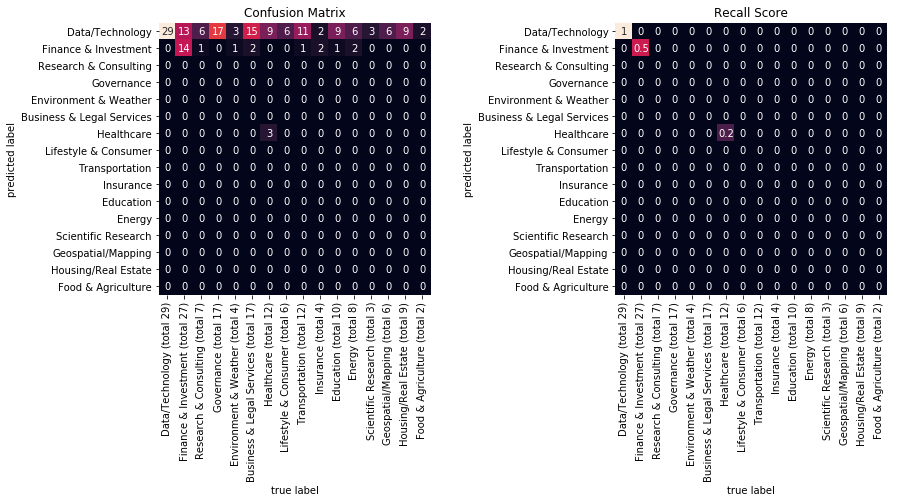

In [77]:
## heatmap for the confusion matrix & recall score
plot_confusion_matrix(y_test, y_predict, clf)

As shown above, the algorithm didn't perform well on either the training data or the test data. From the heatmap on the left side, we can see that regardless of the features, most of the companies are predicted as Data/Technology. We remembered from earlier that this is an imbalanced data and the result could bias towards the major class. To solve this, I will apply over-sampling technique to balance the data.  

In [78]:
## balance the training set

from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=3, random_state=12)
X_sm, y_sm = sm.fit_sample(X_train_tfidf, y_train)

#Count the number of occurences in the y_train sets to ensure that the oversampling worked 
from collections import Counter
class_check_woSMOTE = Counter(y_train)
class_check_words = Counter(y_sm)
print('class_check_woSMOTE: ', class_check_woSMOTE)
print('class_check_words: ', class_check_words)

class_check_woSMOTE:  Counter({0: 67, 1: 48, 5: 30, 6: 29, 3: 26, 13: 24, 2: 21, 11: 20, 7: 17, 8: 16, 12: 14, 14: 12, 10: 9, 4: 7, 9: 7, 15: 4})
class_check_words:  Counter({0: 67, 1: 67, 2: 67, 3: 67, 4: 67, 5: 67, 6: 67, 7: 67, 8: 67, 9: 67, 10: 67, 11: 67, 12: 67, 13: 67, 14: 67, 15: 67})


Now we can see that each class has 67 samples in it. The dataset is balanced. We will fit the MultinomialNB again on the balanced data. 

In [129]:
clf_balanced = MultinomialNB().fit(X_sm, y_sm)

In [80]:
y_predict_train, y_predict = get_prediction(clf_balanced, X_train_tfidf, X_test_tfidf)
calculate_accuracy(y_train, y_test, y_predict_train, y_predict)

Accuracy on training set:  0.9715099715099715
Accuracy on test set:  0.6416184971098265


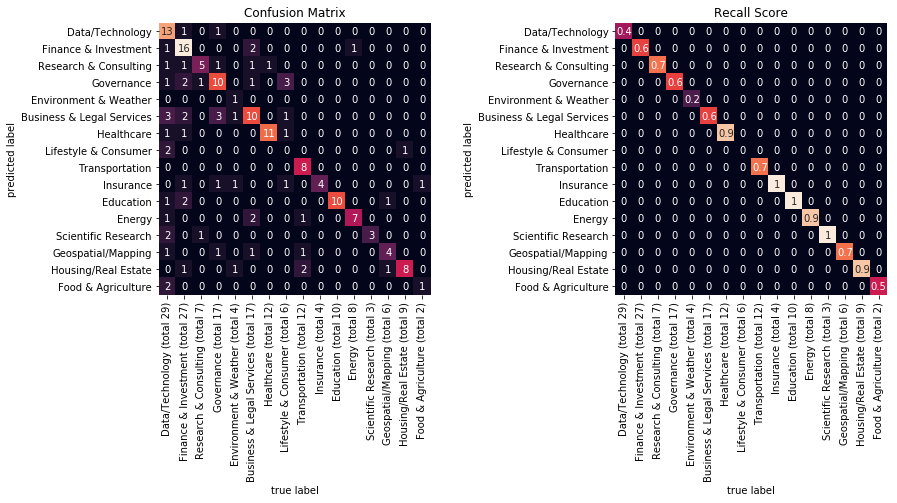

In [81]:
#fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1)
plot_confusion_matrix(y_test, y_predict, clf_balanced)

With balanced classes, the accuracy has increased from 0.266 to 0.642. More values start to emerge on the diagonal of the heatmap, which indicates correct prediction. Let's test out the model on some samples.

In [126]:
## randomly pick some descriptions
print(desc_ind['normalized_description'][23])
print("")
print(desc_ind['normalized_description'][50])
print("")
print(desc_ind['normalized_description'][105])

aquicore energy intelligence solution combine software next generation meter technology cost effectively monitor analyze real time energy datum across commercial real estate property aquicor platform centraliz critical energy datum provide intuitive graphical interface streamline management team collaboration hardware allow cost effective rapid deployment across hundred property matter month regardless building age size bms system aquicor platform enable organization make timely decision improve staff productivity reduce energy waste increase tenant satisfaction meet strategic energy goal

blackrock offer mutual fund closed end fund manage account alternative investment individual institution financial professional mission create good financial future client

high medical bill lead personal bankruptcy usa primary lack price quality transparency medical industry two provider maryland charge significantly different price procedure quality care patient typically know cost procedure receiv

In [127]:
## get the labels of the above mentioned descriptions
print(desc_ind['company_category'][23], ': category_id', category_to_id[desc_ind['company_category'][23]])
print(desc_ind['company_category'][50], ': category_id', category_to_id[desc_ind['company_category'][50]])
print(desc_ind['company_category'][105], ': category_id', category_to_id[desc_ind['company_category'][105]])

Energy : category_id 11
Finance & Investment : category_id 1
Healthcare : category_id 6


In [130]:
## get the predicted labels of the descriptions to see if they match with the true lables
print(clf_balanced.predict(tfidf.transform(["aquicore energy intelligence solution combine software next generation meter technology cost effectively monitor analyze real time energy datum across commercial real estate property aquicor platform centraliz critical energy datum provide intuitive graphical interface streamline management team collaboration hardware allow cost effective rapid deployment across hundred property matter month regardless building age size bms system aquicor platform enable organization make timely decision improve staff productivity reduce energy waste increase tenant satisfaction meet strategic energy goal"])))
print(clf_balanced.predict(tfidf.transform(["blackrock offer mutual fund closed end fund manage account alternative investment individual institution financial professional mission create good financial future client"])))
print(clf_balanced.predict(tfidf.transform(["high medical bill lead personal bankruptcy usa primary lack price quality transparency medical industry two provider maryland charge significantly different price procedure quality care patient typically know cost procedure receive bill comparedcare found 2013 goal provide patient ability compare cost care among provider within area user may upload input medical bill information anonymously without phi personally identifiable information comparedcare medical bill repository patient actively search cost medical procedure within area comparison well read physician review submit patient one stop shop medical pricing patient"])))

[11]
[1]
[6]


All of the three predictions are correct. Not bad! 

#### Model Selection

There are many other models that could be used for text classification. The following evaluation is conducted to compare different model performance on this dataset. 

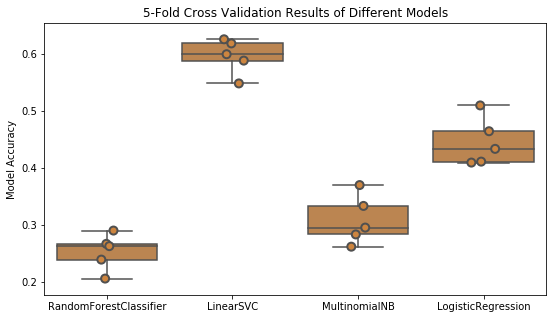

In [85]:
## compare model performance of RandomForest, LinearSVC, MultinomialNB and Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),

]
cv = 5
cv_df = pd.DataFrame(index=range(cv * len(models)))
entries = []
#model_name_mapping = {"RandomForestClassifier": "RF", "LinearSVC": "LSVC", "MultinomialNB": "MNB"
                      #, "LogisticRegression": "LR"}
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=cv)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

fig, ax = plt.subplots(figsize=(9,5))
sns.boxplot(x='model_name', y='accuracy', data=cv_df, ax=ax, color="peru")
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2, color="peru")
plt.title("5-Fold Cross Validation Results of Different Models")
plt.xlabel("")
plt.ylabel("Model Accuracy")
plt.show()

In [86]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.596554
LogisticRegression        0.445803
MultinomialNB             0.308688
RandomForestClassifier    0.252768
Name: accuracy, dtype: float64

The above chart and table suggest that among the four models tested, LinearSVC performs better than the other three classifiers with a median accuracy around 59%. We will then apply LinearSVC on our data to evaluate the results.

#### LinearSVC Model

In [131]:
## train test split
X = desc_ind['normalized_description']
y = desc_ind['category_id']
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, desc_ind.index, test_size=0.33, random_state=1)

In [132]:
## text vectorizing
tfidf = TfidfVectorizer(min_df=2, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [133]:
## balance the training set
from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=3, random_state=12)
X_sm, y_sm = sm.fit_sample(X_train_tfidf, y_train)

In [90]:
## fit the model
model = LinearSVC().fit(X_sm, y_sm)

y_predict_train, y_predict = get_prediction(model, X_train_tfidf, X_test_tfidf)
calculate_accuracy(y_train, y_test, y_predict_train, y_predict)

Accuracy on training set:  1.0
Accuracy on test set:  0.6763005780346821


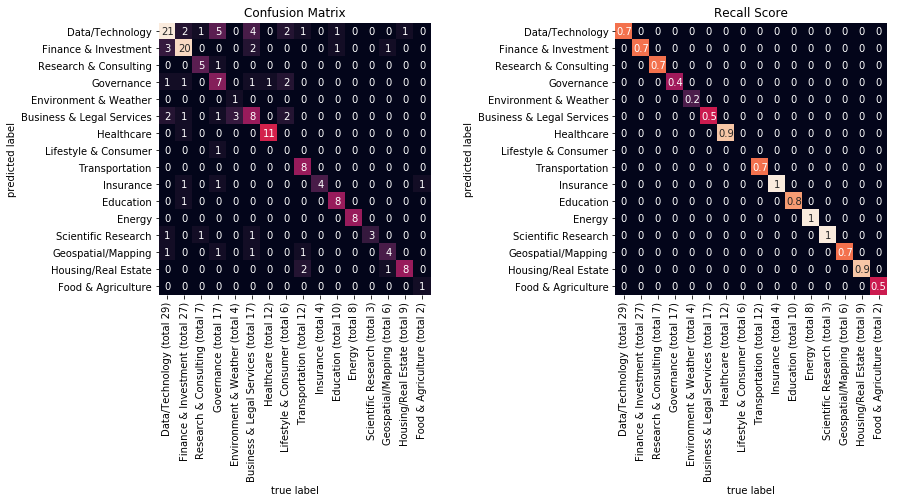

In [91]:
plot_confusion_matrix(y_test, y_predict, model)

In [134]:
## classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, target_names=list(id_to_category.values())))

                           precision    recall  f1-score   support

          Data/Technology       0.58      0.72      0.65        29
     Finance & Investment       0.74      0.74      0.74        27
    Research & Consulting       1.00      0.71      0.83         7
               Governance       0.69      0.53      0.60        17
    Environment & Weather       1.00      0.25      0.40         4
Business & Legal Services       0.47      0.47      0.47        17
               Healthcare       0.92      0.92      0.92        12
     Lifestyle & Consumer       1.00      0.17      0.29         6
           Transportation       1.00      0.75      0.86        12
                Insurance       0.57      1.00      0.73         4
                Education       0.90      0.90      0.90        10
                   Energy       1.00      1.00      1.00         8
      Scientific Research       0.43      1.00      0.60         3
       Geospatial/Mapping       0.50      0.67      0.57     

The accuracy score has increased to 0.676 by using LinearSVC. The model have improved the recall score for both Data/Technology and Finance & Investment and kept the score for other classes almost intact. 

So far, we have built the corpus based on the training data after the train test split. What if we build the vocabulary before the split? Since we only have 524 samples, it might make sense to use all the documents to build the corpus. If in the future we are able to obtain more profiles, we could then retrain the corpus to include more words. 

#### LinearSVC with Corpus Built on Entire Document

In [152]:
## build corpus with all documents
X = desc_ind['normalized_description']
y = desc_ind['category_id']
tfidf = TfidfVectorizer(min_df=2, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.33, random_state=1)
features_size_complete = X_train.toarray().shape[1]
print('Corpus Size of Training Set: ', feature_size)
print('Corpus Size of Entire Document: ', features_size_complete)

Corpus Size of Training Set:  2505
Corpus Size of Entire Document:  3624


In [153]:
## balance the training dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=3, random_state=12)
X_sm, y_sm = sm.fit_sample(X_train, y_train)

In [154]:
## fit the model
SVC = LinearSVC().fit(X_sm, y_sm)
y_predict_train, y_predict = get_prediction(SVC, X_train, X_test)
calculate_accuracy(y_train, y_test, y_predict_train, y_predict)

Accuracy on training set:  1.0
Accuracy on test set:  0.7052023121387283


By including all the documents in the corpus, we increased the corpus size from 2505 features to 3624 features. The result was a 3% improvement in the test accuracy, which reached 0.705. 

#### Feature Tuning

There are several parameters I would like to look into, k_neighbors in SMOTE, the penalty parameter C in LinearSVC, and the parameters of TfidfVectorizer. After testing for various k_neighbors, the value k_neighbors equals 1 generated the best result. Thus here, I will use k_neighbors equals 1 to randomly duplicate some of the records in the minority class. As mentioned before, we will use min_df=2 in TfidVectorizer to exclude some of the words that are unique to a particular business description. We also remember from earlier that some words such as provide, service, company, and business are seen in many of the descriptions and don't really correlate to any of the industries. Thus, I will also add max_df=0.4 to exclude words that appear in more than 40% of the documents. Then I tested C for several values in the range of 0.04 to 1 to choose the optimal paramter. 

In [158]:
## text vectorizing
X = desc_ind['normalized_description']
y = desc_ind['category_id']
tfidf = TfidfVectorizer(min_df=2, max_df=0.4, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.33, random_state=1)

In [159]:
## balance the dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=1, random_state=12)
X_sm, y_sm = sm.fit_sample(X_train, y_train)

In [160]:
## choosing optimal C of LinearSVC
for c in [0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 1]:
    model = LinearSVC(C=c)
    model.fit(X_sm, y_sm)
    y_pred = model.predict(X_test)
    y_predict_train = model.predict(X_sm)
    print('Accuracy on training set (c={}): '.format(c), metrics.accuracy_score(y_sm, y_predict_train))
    print('Accuracy on test set: c={})'.format(c), metrics.accuracy_score(y_test, y_pred))

Accuracy on training set (c=0.04):  0.9878731343283582
Accuracy on test set: c=0.04) 0.6878612716763006
Accuracy on training set (c=0.05):  0.9888059701492538
Accuracy on test set: c=0.05) 0.7167630057803468
Accuracy on training set (c=0.06):  0.9906716417910447
Accuracy on test set: c=0.06) 0.7167630057803468
Accuracy on training set (c=0.07):  0.9925373134328358
Accuracy on test set: c=0.07) 0.7225433526011561
Accuracy on training set (c=0.08):  0.9925373134328358
Accuracy on test set: c=0.08) 0.7167630057803468
Accuracy on training set (c=0.1):  0.9934701492537313
Accuracy on test set: c=0.1) 0.7109826589595376
Accuracy on training set (c=1):  1.0
Accuracy on test set: c=1) 0.7109826589595376


Among all the values tested above, the best C is 0.07 and we will use the best C to build our final classifier. 

In [163]:
## fit the model with best parameter
best_model = LinearSVC(C=0.07)
best_model.fit(X_sm, y_sm)

y_predict_train, y_predict = get_prediction(best_model, X_train, X_test)
calculate_accuracy(y_train, y_test, y_predict_train, y_predict)

Accuracy on training set:  0.9772079772079773
Accuracy on test set:  0.7225433526011561


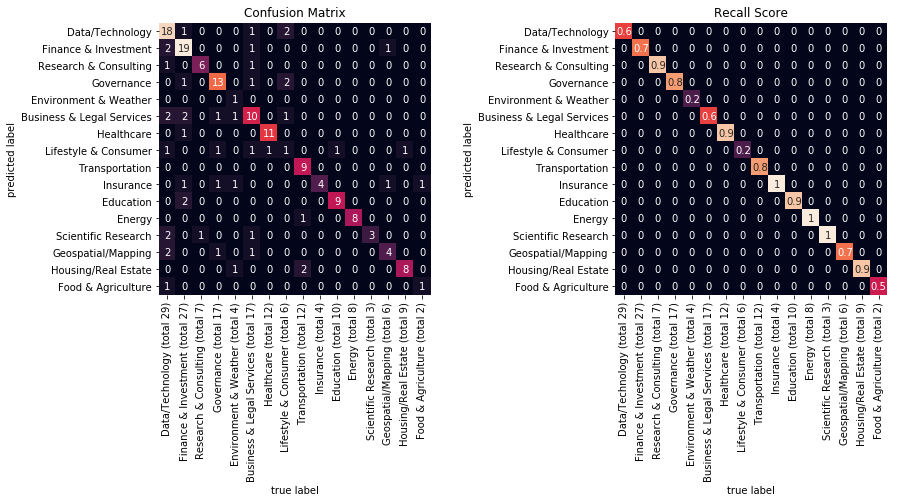

In [162]:
plot_confusion_matrix(y_test, y_predict, best_model)

In [165]:
## classification report
print(classification_report(y_test, y_predict, target_names=list(id_to_category.values())))

                           precision    recall  f1-score   support

          Data/Technology       0.82      0.62      0.71        29
     Finance & Investment       0.83      0.70      0.76        27
    Research & Consulting       0.75      0.86      0.80         7
               Governance       0.76      0.76      0.76        17
    Environment & Weather       1.00      0.25      0.40         4
Business & Legal Services       0.59      0.59      0.59        17
               Healthcare       0.92      0.92      0.92        12
     Lifestyle & Consumer       0.14      0.17      0.15         6
           Transportation       1.00      0.75      0.86        12
                Insurance       0.44      1.00      0.62         4
                Education       0.82      0.90      0.86        10
                   Energy       0.89      1.00      0.94         8
      Scientific Research       0.43      1.00      0.60         3
       Geospatial/Mapping       0.50      0.67      0.57     

So far, we have reached a test accuracy of 0.723, with 125 out of 173 profiles predicted correctly. However, for those profiles that are misclassified, it would be interesting to see what those are caused by. 

In [166]:
# Find misclassified texts
from IPython.display import display
pd.set_option('display.max_colwidth', -1)

mat = confusion_matrix(y_test, y_predict)
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and mat[actual, predicted] >= 2:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], mat[actual, predicted]))
            display(desc_ind.loc[indices_test[(y_test == actual) & (y_predict == predicted)]][['company_category', 'normalized_description']])
            print('')

'Lifestyle & Consumer' predicted as 'Data/Technology' : 2 examples.


,company_category,normalized_description
181,Lifestyle & Consumer,fuzion app mission end wage gap woman minority within year challenge wage gap aequita mobile cloud solution enable user take control career make informed decision
99,Lifestyle & Consumer,cloudspyre llc boutique custom software development company specialize develop mobile cloud web base software solution build ios android blackberry app help people learn world around cloudspyre also partner company programming side creative project cloudspyre expertise develop website large variety application platform favorite build ruby rail website custom backend website cloudspyre app build ruby rail



'Data/Technology' predicted as 'Finance & Investment' : 2 examples.


,company_category,normalized_description
102,Data/Technology,collective ip found singular mission accelerate commercialization global rd marketplace uniquely surface idea technology inventor quickly catalyze connection buyer seller asset revolutionary way accomplish goal build comprehensive accurate organization technology emerge university company inventor
40,Data/Technology,barchartcom full service provider future equity foreign exchange market datum barchart provide wide range market datum product solution established organization industry demand accuracy innovation barchart goal form partnership deliver comprehensive solution success client financial agricultural energy medium industry



'Lifestyle & Consumer' predicted as 'Governance' : 2 examples.


,company_category,normalized_description
515,Lifestyle & Consumer,workhand free community worker trade show great connect job coworker find tool equipment display license meeting place american worker build maintain fix haul hero spend day get hand dirty make country run workhand show capable building fix maintain haul
510,Lifestyle & Consumer,wemakeitsafer mission dramatically reduce number product relate injury illness death occur year worldwide save life help build strong socially responsible financially stable company



'Data/Technology' predicted as 'Business & Legal Services' : 2 examples.


,company_category,normalized_description
108,Data/Technology,computer package inc provide intellectual property management system patent annuity payment service exclusive patent audit service improve ability manage acquisition andor divestiture efficiently
111,Data/Technology,connotate transform web datum content high value information asset feed content product grow market business intelligence enable mass datum aggregation migration integrationconnotate patent intelligent agent technology empower business user programmer quickly create data set new application content product connotate customer experience productivity gain reduced cost mitigated risk informed decision making strategic competitive advantage



'Finance & Investment' predicted as 'Business & Legal Services' : 2 examples.


,company_category,normalized_description
506,Finance & Investment,webfiling aim reinvent business reporting company provide cloud base collaboration solution eliminate version control issue important challenging report include external filing wdesk use role base access single document datamodel technology improve speed review approve sophisticated linking validation feature reinforce accuracy compliance throughout reporting process wdesk secure enable professional take control business reporting datum
43,Finance & Investment,mandasoftcom provide berkery nof information service provide merger acquisition datum via hosted searchable database base berkery noye information industry weekly report resource merger acquisition datum many top executive company shape future information although anyone interested would find mandasoftcom useful service gear towards c level executive want quickly find review information industry transaction company eye toward find match product service



'Finance & Investment' predicted as 'Education' : 2 examples.


,company_category,normalized_description
103,Finance & Investment,ecmc initiative college abacus free service allow user compare project financial aid package across school identify school within budget use net price calculator npcs build us college mandate high education opportunity act college abacus build system generate estimate post secondary institution united state
315,Finance & Investment,nerdwallet nerd create great tool crunch number give result unfiltered unbiased matter money question banking insurance health care investment education housing travel shopping offer data drive tool impartial information help make solid decision moneywe clear tool user friendly unbiased use number base analytic approach give objective results personalize customize result base financial preferences complete site list product service make money include everything findsome way help guard money choose credit card help find one save give good rewards find deal help shop smart bargain coupon invest money help avoid rip figure money stay safe grow stay get healthy help find affordable healthcare good insurance good hospitals pay college help find scholarship calculate loan compare college include law school mba program



'Data/Technology' predicted as 'Scientific Research' : 2 examples.


,company_category,normalized_description
120,Data/Technology,crowdanalytix demand crowd source service provide datum science expertise analytic manager team enterprise professional service firm crowdanalytix operate crowdsourc platform large grow community independent datum scientist solve customer problem use datum science contest publicly access datum crowdanalytix solution manager responsible manage partner project community completioncrowdanalytix headquarter silicon valley receive investment lead venture capital firmsfor information please visit wwwcrowdanalytixcompartner
340,Data/Technology,mission orlin research inc produce software product multiply power efficiency empirical research social science goal expand access complex datum source advance method scientific investigation use analyze



'Data/Technology' predicted as 'Geospatial/Mapping' : 2 examples.


,company_category,normalized_description
427,Data/Technology,social explorer easy use demographic website web base application create fast intuitive visually appeal map report social explorer anyone internet connection access work census dataour mission build simple easy use fun demographic website world
163,Data/Technology,factual datum company help developer publisher advertiser build relevant personalize mobile experience use context location



'Transportation' predicted as 'Housing/Real Estate' : 2 examples.


,company_category,normalized_description
482,Transportation,uber aim evolve way world move seamlessly connect rider driver app make city accessible open possibility rider business driver operate city today uber rapidly expand global presence continue bring people city closer
441,Transportation,spothero provide parking location chicago area expand city around us spothero mission bring exceptional service incredible deal city across united state one time add city around country


As we can see, companies misclassified as Business & Legal Services contain words such as intellectual property and patent, companies categorized as Education do provide services to colleges and education institutes. Most of the misclassifications make sense and are difficult for the algorithm to place them in the correct class. 

### <font color=#3090C7>CONCLUSIONS & FUTURE WORK</font>

To conclude, we have constructed a relatively accurate classifier to determin the industry segment of a company based on its business description. To build the final classifier, we gradually improved the features by balancing the data and tuned the hyperparameters of the text vectorizer. We also experimented different models and different hyperparameters of the models to evaluate the results. By using LinearSVC, we were able to achieve 72.25% accuracy on our test set. (The results and progression of various models can be found [here](https://docs.google.com/spreadsheets/d/1eIsOUDVAN7AatynulduX6Rpv8PxrMTfQ972D71gzk6M/edit#gid=0).

For the analysis in this report, we were only able to obtain around 500 records with majority of the samples belong to two classes. Ideally, we would want to collect more data to build a more complete and representative corpus, especially for the companies in the smaller classes. In addition, steps such as expanding the feature set and using ensemble methods to combine different classifiers have the potential to further improve the results in the future. 

Given more time, we would try other applications to the text analysis such as latent dirichlet allocation (LDA), which we could use to group the companies into their own clusters. We can then identify the most frequent words and topics in each cluster and generate a list of keywords that are specific to each topic. Those keywords could be tagged to the company profiles for a broader range of research analysis.

### <font color=#3090C7>RECOMMENDATIONS TO THE CLIENT</font>

Currently, data collection on company profiles and investments involves a large amount of manual work and labor time. The automatic cateloging described in this report could drastically improve the efficiency of information tagging and data input. The machine learning approach could be utilized by data providers, investment firms, and service providers such as law firms and accounting firms. For clients who are going to apply the algorithm, it is recommended to train the model with large enough data to increase the accuracy of the prediction. 

At the initial phase of using this model, it is recommended to implement a transition period where we would have human to check the results and retrain the model accordingly. As seen in the previous analysis, we gained a 3% increase in accuracy when we included roughly 1120 more words in the corpus. It is highly possible that the model would perform even better if we retrain it with more data in the future. It will eventually reach a point when adding more company profiles won't generate much more words to add to the dictionary or adding more words don't produce better results. Once the model reaches its stable and better status, we could then gradually phase out the human work and realize true automation. 